# v21.2 Training - Korean Synonym Enhancement (Legal/Medical)

This notebook trains a Korean-focused SPLADE model with enhanced legal and medical domain vocabulary.

## Changes from v21.1

| Feature | v21.1 | v21.2 |
|---------|-------|-------|
| Domains | 10 general | **14 domains (+법률, +의료)** |
| Learning Rate | 5e-6 | **3e-6 (slower for stability)** |
| Epochs | 20 | **25 (more training)** |
| Lambda Self | 3.0 | **4.0 (stronger self-preservation)** |
| Lambda Synonym | 8.0 | **10.0 (stronger synonym activation)** |
| Lambda FLOPS | 5e-3 | **8e-3 (more sparsity)** |
| Warmup Ratio | 0.1 | **0.15 (longer warmup)** |

In [1]:
import sys
from pathlib import Path

def find_project_root():
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Tuple
import random
import numpy as np

print(f"Project root: {PROJECT_ROOT}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train
PyTorch version: 2.10.0.dev20251109+cu130
CUDA available: True
GPU: NVIDIA GB10


/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


In [2]:
# Set random seed
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

## 1. Configuration

In [3]:
# Training configuration - v21.2 with tuned hyperparameters
CONFIG = {
    # Model
    "model_name": "skt/A.X-Encoder-base",  # Korean-optimized encoder
    "max_length": 64,

    # Data - v21.2 legal/medical dataset
    "train_data_path": PROJECT_ROOT / "dataset" / "v21.2_korean_legal_medical" / "train_dataset",
    "test_data_path": PROJECT_ROOT / "dataset" / "v21.2_korean_legal_medical" / "test_dataset",

    # Training - Tuned hyperparameters for v21.2
    "batch_size": 64,
    "gradient_accumulation_steps": 2,
    "num_epochs": 25,              # Increased from 20 for more training
    "learning_rate": 3e-6,         # Reduced from 5e-6 for stability
    "warmup_ratio": 0.15,          # Increased from 0.1 for longer warmup
    "max_grad_norm": 1.0,

    # Loss weights - Tuned for better synonym expansion
    "lambda_self": 4.0,            # Increased from 3.0 for stronger self-preservation
    "lambda_synonym": 10.0,        # Increased from 8.0 for stronger synonym activation
    "lambda_margin": 2.5,          # Increased from 2.0 for better margin
    "lambda_distill": 1.0,         # Keep same
    "lambda_flops": 8e-3,          # Increased from 5e-3 for more sparsity
    "target_margin": 1.5,          # Keep same

    # FP16
    "use_fp16": True,

    # Output - v21.2
    "output_dir": PROJECT_ROOT / "outputs" / "v21.2_korean_legal_medical",
}

# Create output directory
CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)

print("Configuration (v21.2 - Tuned Hyperparameters):")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration (v21.2 - Tuned Hyperparameters):
  model_name: skt/A.X-Encoder-base
  max_length: 64
  train_data_path: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21.2_korean_legal_medical/train_dataset
  test_data_path: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21.2_korean_legal_medical/test_dataset
  batch_size: 64
  gradient_accumulation_steps: 2
  num_epochs: 25
  learning_rate: 3e-06
  warmup_ratio: 0.15
  max_grad_norm: 1.0
  lambda_self: 4.0
  lambda_synonym: 10.0
  lambda_margin: 2.5
  lambda_distill: 1.0
  lambda_flops: 0.008
  target_margin: 1.5
  use_fp16: True
  output_dir: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v21.2_korean_legal_medical


## 2. Load Data

In [4]:
from datasets import load_from_disk

# Load train and test datasets (triplet format)
train_dataset_hf = load_from_disk(str(CONFIG["train_data_path"]))
test_dataset_hf = load_from_disk(str(CONFIG["test_data_path"]))

print(f"Train dataset: {len(train_dataset_hf):,} triplets")
print(f"Test dataset: {len(test_dataset_hf):,} triplets")
print(f"Total: {len(train_dataset_hf) + len(test_dataset_hf):,} triplets")

# Dataset format
print(f"\nDataset features: {train_dataset_hf.features}")

# Sample triplets
print("\nSample triplets:")
for i in range(min(5, len(train_dataset_hf))):
    item = train_dataset_hf[i]
    print(f"  {item['anchor']} -> {item['positive']} (neg: {item['negative']})")

Train dataset: 91,816 triplets
Test dataset: 39,350 triplets
Total: 131,166 triplets

Dataset features: {'anchor': Value(dtype='string', id=None), 'positive': Value(dtype='string', id=None), 'negative': Value(dtype='string', id=None)}

Sample triplets:
  본건사고발생 -> 사고 (neg: 본건사고)
  트위터 -> 리트윗 (neg: 소셜미디어)
  이미연 -> 이미경 (neg: 이미자)
  신규가입 -> 신규 (neg: 신규등록)
  핑크색 -> 핑크 (neg: 핑크 팬더)


## 3. Define SPLADE Model

In [5]:
class SPLADEModel(nn.Module):
    """
    SPLADE model for Korean sparse retrieval.
    
    Uses log(1 + ReLU(MLM_logits)) for sparse representation.
    """

    def __init__(self, model_name: str = "skt/A.X-Encoder-base"):
        super().__init__()
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.config = self.model.config
        self.relu = nn.ReLU()

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass.

        Args:
            input_ids: Token IDs [batch, seq_len]
            attention_mask: Attention mask [batch, seq_len]

        Returns:
            sparse_repr: Sparse representation [batch, vocab_size]
            token_weights: Per-token weights [batch, seq_len]
        """
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch, seq_len, vocab_size]

        # SPLADE activation: log(1 + ReLU(x))
        token_scores = torch.log1p(self.relu(logits))

        # Mask padding tokens
        mask = attention_mask.unsqueeze(-1).float()
        token_scores = token_scores * mask

        # Max pooling over sequence
        sparse_repr, _ = token_scores.max(dim=1)  # [batch, vocab_size]

        # Token weights for analysis
        token_weights = token_scores.max(dim=-1).values  # [batch, seq_len]

        return sparse_repr, token_weights

## 4. Define Dataset

In [6]:
class TripletDataset(Dataset):
    """
    Dataset for triplet-based training.
    
    Each sample contains:
    - anchor: Source term
    - positive: Synonym (positive example)
    - negative: Hard negative (similar but not synonym)
    """

    def __init__(self, hf_dataset, tokenizer, max_length: int = 64):
        self.hf_dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.hf_dataset)

    def __getitem__(self, idx: int) -> Dict:
        item = self.hf_dataset[idx]
        return {
            "anchor": item["anchor"],
            "positive": item["positive"],
            "negative": item["negative"],
        }


def triplet_collate_fn(batch: List[Dict], tokenizer, max_length: int = 64) -> Dict:
    """
    Collate function for triplet DataLoader.
    """
    anchors = [item["anchor"] for item in batch]
    positives = [item["positive"] for item in batch]
    negatives = [item["negative"] for item in batch]

    # Tokenize all
    anchor_encodings = tokenizer(
        anchors, padding=True, truncation=True, max_length=max_length, return_tensors="pt"
    )
    positive_encodings = tokenizer(
        positives, padding=True, truncation=True, max_length=max_length, return_tensors="pt"
    )
    negative_encodings = tokenizer(
        negatives, padding=True, truncation=True, max_length=max_length, return_tensors="pt"
    )

    return {
        "anchor_input_ids": anchor_encodings["input_ids"],
        "anchor_attention_mask": anchor_encodings["attention_mask"],
        "positive_input_ids": positive_encodings["input_ids"],
        "positive_attention_mask": positive_encodings["attention_mask"],
        "negative_input_ids": negative_encodings["input_ids"],
        "negative_attention_mask": negative_encodings["attention_mask"],
        "anchors": anchors,
        "positives": positives,
        "negatives": negatives,
    }

## 5. Define Loss Functions

In [7]:
def compute_self_loss(
    sparse_repr: torch.Tensor,
    input_ids: torch.Tensor,
    attention_mask: torch.Tensor,
) -> torch.Tensor:
    """
    Self-reconstruction loss: Source term should activate its own tokens.
    """
    batch_size = input_ids.shape[0]
    loss = 0.0

    for i in range(batch_size):
        # Get non-padding, non-special token indices
        valid_mask = attention_mask[i].bool()
        token_ids = input_ids[i][valid_mask]

        # Skip special tokens (CLS, SEP, PAD)
        token_ids = token_ids[1:-1]  # Remove CLS and SEP

        if len(token_ids) > 0:
            # Get weights for source tokens
            weights = sparse_repr[i][token_ids]
            # Maximize these weights (minimize negative)
            loss -= weights.mean()

    return loss / batch_size


def compute_positive_loss(
    anchor_repr: torch.Tensor,
    positive_input_ids: torch.Tensor,
    positive_attention_mask: torch.Tensor,
) -> torch.Tensor:
    """
    Positive loss: Anchor should activate tokens from positive (synonym).
    """
    batch_size = anchor_repr.shape[0]
    loss = 0.0

    for i in range(batch_size):
        # Get positive token IDs (non-special)
        valid_mask = positive_attention_mask[i].bool()
        token_ids = positive_input_ids[i][valid_mask]
        token_ids = token_ids[1:-1]  # Remove CLS and SEP

        if len(token_ids) > 0:
            # Get anchor weights for positive tokens
            positive_weights = anchor_repr[i][token_ids]
            # Maximize these weights
            loss -= positive_weights.mean()

    return loss / batch_size


def compute_triplet_margin_loss(
    anchor_repr: torch.Tensor,
    positive_repr: torch.Tensor,
    negative_repr: torch.Tensor,
    margin: float = 1.0,
) -> torch.Tensor:
    """
    Triplet margin loss: anchor-positive distance < anchor-negative distance.
    """
    # Cosine similarity
    pos_sim = F.cosine_similarity(anchor_repr, positive_repr)
    neg_sim = F.cosine_similarity(anchor_repr, negative_repr)
    
    # Hinge loss: want pos_sim > neg_sim + margin
    loss = F.relu(margin - pos_sim + neg_sim)
    
    return loss.mean()


def compute_flops_loss(sparse_repr: torch.Tensor) -> torch.Tensor:
    """
    FLOPS regularization: Penalize frequently activated tokens.
    
    This encourages sparsity and reduces noise.
    """
    # Mean activation per token across batch
    mean_activation = sparse_repr.mean(dim=0)
    # Sum of squared means (penalize tokens that are always active)
    return (mean_activation ** 2).sum()

## 6. Initialize Model and Tokenizer

In [8]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])
print(f"Tokenizer: {CONFIG['model_name']}")
print(f"Vocab size: {tokenizer.vocab_size:,}")

# Load model
model = SPLADEModel(CONFIG["model_name"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model loaded on {device}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Tokenizer: skt/A.X-Encoder-base
Vocab size: 49,999
Model loaded on cuda
Parameters: 149,372,240


In [9]:
# Create train and test datasets
train_dataset = TripletDataset(
    hf_dataset=train_dataset_hf,
    tokenizer=tokenizer,
    max_length=CONFIG["max_length"],
)

test_dataset = TripletDataset(
    hf_dataset=test_dataset_hf,
    tokenizer=tokenizer,
    max_length=CONFIG["max_length"],
)

# Create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    collate_fn=lambda batch: triplet_collate_fn(batch, tokenizer, CONFIG["max_length"]),
    num_workers=0,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    collate_fn=lambda batch: triplet_collate_fn(batch, tokenizer, CONFIG["max_length"]),
    num_workers=0,
)

print(f"Train dataset: {len(train_dataset):,} triplets")
print(f"Test dataset: {len(test_dataset):,} triplets")
print(f"Train batches per epoch: {len(train_dataloader):,}")
print(f"Test batches: {len(test_dataloader):,}")

Train dataset: 91,816 triplets
Test dataset: 39,350 triplets
Train batches per epoch: 1,435
Test batches: 615


## 7. Training Loop

In [10]:
# Optimizer and scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=0.01,
)

num_training_steps = len(train_dataloader) * CONFIG["num_epochs"] // CONFIG["gradient_accumulation_steps"]
num_warmup_steps = int(num_training_steps * CONFIG["warmup_ratio"])

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

# FP16 scaler
scaler = torch.amp.GradScaler("cuda", enabled=CONFIG["use_fp16"])

print(f"Training steps: {num_training_steps:,}")
print(f"Warmup steps: {num_warmup_steps:,}")

Training steps: 17,937
Warmup steps: 2,690


In [11]:
def evaluate_model(model, tokenizer, device):
    """
    Evaluate Korean synonym expansion including legal and medical domains.
    """
    model.eval()
    
    # Test cases with expected Korean synonyms (including legal/medical)
    test_cases = [
        # General
        ("추천", ["권장", "제안", "권유", "소개"]),
        ("검색", ["탐색", "조회", "찾기", "서치"]),
        ("인공지능", ["AI", "에이아이", "기계지능"]),
        ("기계학습", ["머신러닝", "ML", "자동학습"]),
        ("데이터베이스", ["DB", "디비", "자료저장소"]),
        # Legal domain (법률)
        ("손해배상", ["배상", "보상", "책임", "손해"]),
        ("판결", ["판례", "선고", "결정", "심판"]),
        ("소송", ["재판", "소", "송사", "고소"]),
        ("계약", ["약정", "협정", "체결", "합의"]),
        ("위반", ["위법", "불법", "범법", "어김"]),
        # Medical domain (의료)
        ("진단", ["진찰", "검진", "소견", "판단"]),
        ("치료", ["처치", "요법", "치유", "시술"]),
        ("처방", ["투약", "조제", "약처방"]),
        ("증상", ["증세", "증후", "징후", "소견"]),
        ("질환", ["질병", "병", "병증", "환"]),
    ]
    
    # Build special token set
    special_ids = {tokenizer.pad_token_id, tokenizer.cls_token_id, 
                   tokenizer.sep_token_id, tokenizer.unk_token_id}
    special_ids = {t for t in special_ids if t is not None}
    
    source_preserved = 0
    synonym_activated = 0
    total = len(test_cases)
    
    with torch.no_grad():
        for source, expected_synonyms in test_cases:
            # Encode source
            inputs = tokenizer(source, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            weights, _ = model(inputs["input_ids"], inputs["attention_mask"])
            weights = weights[0]
            
            # Mask special tokens
            for tid in special_ids:
                weights[tid] = -float('inf')
            
            # Get top tokens
            top_k = 15
            top_indices = weights.topk(top_k).indices.tolist()
            top_tokens = [tokenizer.decode([idx]).strip() for idx in top_indices]
            
            # Check source preservation
            if any(source in tok or tok in source for tok in top_tokens if tok):
                source_preserved += 1
            
            # Check synonym activation
            for syn in expected_synonyms:
                if any(syn.lower() in tok.lower() or tok.lower() in syn.lower() 
                       for tok in top_tokens if tok):
                    synonym_activated += 1
                    break
    
    model.train()
    
    source_rate = source_preserved / total * 100
    synonym_rate = synonym_activated / total * 100
    combined = source_rate + synonym_rate
    
    return source_rate, synonym_rate, combined

In [12]:
# Training loop with triplet loss
history = []
best_combined_score = 0
best_epoch = 0

print("Starting training with triplet loss...")
print("=" * 80)

for epoch in range(CONFIG["num_epochs"]):
    model.train()
    epoch_losses = {
        "total": 0.0,
        "self": 0.0,
        "positive": 0.0,
        "triplet_margin": 0.0,
        "flops": 0.0,
    }
    num_batches = 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{CONFIG['num_epochs']}")
    
    for step, batch in enumerate(progress_bar):
        # Move to device
        anchor_input_ids = batch["anchor_input_ids"].to(device)
        anchor_attention_mask = batch["anchor_attention_mask"].to(device)
        positive_input_ids = batch["positive_input_ids"].to(device)
        positive_attention_mask = batch["positive_attention_mask"].to(device)
        negative_input_ids = batch["negative_input_ids"].to(device)
        negative_attention_mask = batch["negative_attention_mask"].to(device)
        
        with torch.amp.autocast("cuda", enabled=CONFIG["use_fp16"]):
            # Forward pass for anchor, positive, negative
            anchor_repr, _ = model(anchor_input_ids, anchor_attention_mask)
            positive_repr, _ = model(positive_input_ids, positive_attention_mask)
            negative_repr, _ = model(negative_input_ids, negative_attention_mask)
            
            # Compute losses
            loss_self = compute_self_loss(anchor_repr, anchor_input_ids, anchor_attention_mask)
            loss_positive = compute_positive_loss(anchor_repr, positive_input_ids, positive_attention_mask)
            loss_triplet_margin = compute_triplet_margin_loss(
                anchor_repr, positive_repr, negative_repr,
                margin=CONFIG["target_margin"]
            )
            loss_flops = compute_flops_loss(anchor_repr)
            
            # Total loss
            total_loss = (
                CONFIG["lambda_self"] * loss_self +
                CONFIG["lambda_synonym"] * loss_positive +
                CONFIG["lambda_margin"] * loss_triplet_margin +
                CONFIG["lambda_flops"] * loss_flops
            )
            
            total_loss = total_loss / CONFIG["gradient_accumulation_steps"]
        
        # Backward pass
        scaler.scale(total_loss).backward()
        
        # Accumulate losses
        epoch_losses["total"] += total_loss.item() * CONFIG["gradient_accumulation_steps"]
        epoch_losses["self"] += loss_self.item()
        epoch_losses["positive"] += loss_positive.item()
        epoch_losses["triplet_margin"] += loss_triplet_margin.item()
        epoch_losses["flops"] += loss_flops.item()
        num_batches += 1
        
        # Optimizer step
        if (step + 1) % CONFIG["gradient_accumulation_steps"] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG["max_grad_norm"])
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        # Update progress bar
        progress_bar.set_postfix({
            "loss": f"{total_loss.item() * CONFIG['gradient_accumulation_steps']:.4f}",
            "self": f"{loss_self.item():.4f}",
            "pos": f"{loss_positive.item():.4f}",
            "margin": f"{loss_triplet_margin.item():.4f}",
        })
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= num_batches
    
    # Evaluate on test set
    source_rate, synonym_rate, combined_score = evaluate_model(model, tokenizer, device)
    
    # Log
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}:")
    print(f"  Loss: total={epoch_losses['total']:.4f}, self={epoch_losses['self']:.4f}, "
          f"positive={epoch_losses['positive']:.4f}, triplet_margin={epoch_losses['triplet_margin']:.4f}")
    print(f"  Eval: source={source_rate:.1f}%, synonym={synonym_rate:.1f}%, combined={combined_score:.1f}")
    
    # Save history
    history.append({
        **epoch_losses,
        "source_rate": source_rate,
        "synonym_rate": synonym_rate,
        "combined_score": combined_score,
    })
    
    # Save best model
    if combined_score > best_combined_score:
        best_combined_score = combined_score
        best_epoch = epoch + 1
        
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "source_rate": source_rate,
            "synonym_rate": synonym_rate,
            "combined_score": combined_score,
            "config": CONFIG,
        }, CONFIG["output_dir"] / "best_model.pt")
        print(f"  -> New best model saved! (combined={combined_score:.1f})")
    
    # Save checkpoint
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "config": CONFIG,
    }, CONFIG["output_dir"] / f"checkpoint_epoch{epoch + 1}.pt")

print("\n" + "=" * 80)
print(f"Training complete!")
print(f"Best model: Epoch {best_epoch} with combined score {best_combined_score:.1f}")

Starting training with triplet loss...


Epoch 1/25:   0%|          | 0/1435 [00:00<?, ?it/s]

/tmp/ipykernel_2648870/1870897244.py:73: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  scheduler.step()



Epoch 1/25:
  Loss: total=38.4079, self=-2.7690, positive=-2.4189, triplet_margin=1.4960
  Eval: source=100.0%, synonym=100.0%, combined=200.0
  -> New best model saved! (combined=200.0)


Epoch 2/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 2/25:
  Loss: total=-33.5753, self=-3.0646, positive=-2.6607, triplet_margin=1.4253
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 3/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 3/25:
  Loss: total=-35.0482, self=-3.1510, positive=-2.7567, triplet_margin=1.4094
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 4/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 4/25:
  Loss: total=-35.9611, self=-3.1996, positive=-2.8182, triplet_margin=1.3992
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 5/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 5/25:
  Loss: total=-36.7003, self=-3.2366, positive=-2.8677, triplet_margin=1.3908
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 6/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 6/25:
  Loss: total=-37.2795, self=-3.2645, positive=-2.9070, triplet_margin=1.3830
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 7/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 7/25:
  Loss: total=-37.7491, self=-3.2861, positive=-2.9394, triplet_margin=1.3759
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 8/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 8/25:
  Loss: total=-38.1373, self=-3.3038, positive=-2.9661, triplet_margin=1.3692
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 9/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 9/25:
  Loss: total=-38.4598, self=-3.3180, positive=-2.9889, triplet_margin=1.3630
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 10/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 10/25:
  Loss: total=-38.7518, self=-3.3310, positive=-3.0095, triplet_margin=1.3576
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 11/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 11/25:
  Loss: total=-39.0115, self=-3.3428, positive=-3.0281, triplet_margin=1.3522
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 12/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 12/25:
  Loss: total=-39.2413, self=-3.3527, positive=-3.0436, triplet_margin=1.3473
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 13/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 13/25:
  Loss: total=-39.4453, self=-3.3620, positive=-3.0575, triplet_margin=1.3432
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 14/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 14/25:
  Loss: total=-39.6289, self=-3.3706, positive=-3.0703, triplet_margin=1.3393
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 15/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 15/25:
  Loss: total=-39.7921, self=-3.3781, positive=-3.0814, triplet_margin=1.3357
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 16/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 16/25:
  Loss: total=-39.9380, self=-3.3843, positive=-3.0911, triplet_margin=1.3322
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 17/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 17/25:
  Loss: total=-40.0656, self=-3.3903, positive=-3.1000, triplet_margin=1.3294
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 18/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 18/25:
  Loss: total=-40.1796, self=-3.3952, positive=-3.1077, triplet_margin=1.3267
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 19/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 19/25:
  Loss: total=-40.2783, self=-3.3995, positive=-3.1143, triplet_margin=1.3242
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 20/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 20/25:
  Loss: total=-40.3627, self=-3.4034, positive=-3.1198, triplet_margin=1.3220
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 21/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 21/25:
  Loss: total=-40.4326, self=-3.4063, positive=-3.1245, triplet_margin=1.3201
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 22/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 22/25:
  Loss: total=-40.4911, self=-3.4088, positive=-3.1286, triplet_margin=1.3186
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 23/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 23/25:
  Loss: total=-40.5349, self=-3.4106, positive=-3.1313, triplet_margin=1.3173
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 24/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 24/25:
  Loss: total=-40.5657, self=-3.4118, positive=-3.1336, triplet_margin=1.3165
  Eval: source=100.0%, synonym=100.0%, combined=200.0


Epoch 25/25:   0%|          | 0/1435 [00:00<?, ?it/s]


Epoch 25/25:
  Loss: total=-40.5859, self=-3.4125, positive=-3.1349, triplet_margin=1.3159
  Eval: source=100.0%, synonym=100.0%, combined=200.0

Training complete!
Best model: Epoch 1 with combined score 200.0


In [13]:
# Save final model
torch.save({
    "model_state_dict": model.state_dict(),
    "config": CONFIG,
}, CONFIG["output_dir"] / "final_model.pt")

# Save training history
with open(CONFIG["output_dir"] / "training_history.json", "w") as f:
    json.dump(history, f, indent=2, default=str)

print(f"Final model saved to: {CONFIG['output_dir']}")

Final model saved to: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v21.2_korean_legal_medical


## 8. Plot Training Curves

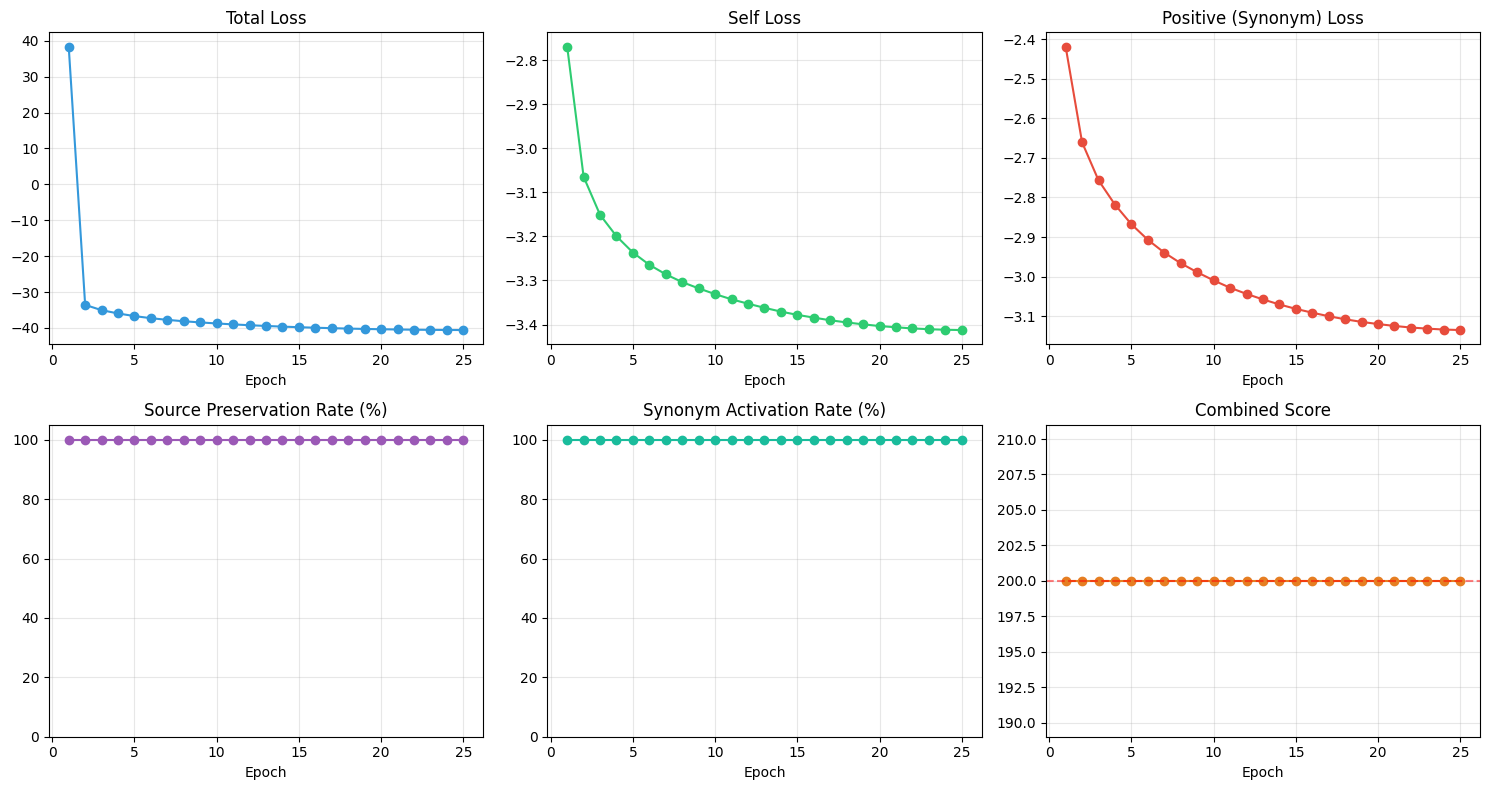

In [14]:
# Plot training curves
epochs = range(1, len(history) + 1)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Total loss
axes[0, 0].plot(epochs, [h["total"] for h in history], "-o", color="#3498db")
axes[0, 0].set_title("Total Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].grid(True, alpha=0.3)

# Self loss
axes[0, 1].plot(epochs, [h["self"] for h in history], "-o", color="#2ecc71")
axes[0, 1].set_title("Self Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].grid(True, alpha=0.3)

# Positive (synonym) loss
axes[0, 2].plot(epochs, [h["positive"] for h in history], "-o", color="#e74c3c")
axes[0, 2].set_title("Positive (Synonym) Loss")
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].grid(True, alpha=0.3)

# Source preservation rate
axes[1, 0].plot(epochs, [h["source_rate"] for h in history], "-o", color="#9b59b6")
axes[1, 0].set_title("Source Preservation Rate (%)")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylim(0, 105)
axes[1, 0].grid(True, alpha=0.3)

# Synonym activation rate
axes[1, 1].plot(epochs, [h["synonym_rate"] for h in history], "-o", color="#1abc9c")
axes[1, 1].set_title("Synonym Activation Rate (%)")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylim(0, 105)
axes[1, 1].grid(True, alpha=0.3)

# Combined score
axes[1, 2].plot(epochs, [h["combined_score"] for h in history], "-o", color="#e67e22")
axes[1, 2].set_title("Combined Score")
axes[1, 2].set_xlabel("Epoch")
axes[1, 2].axhline(y=best_combined_score, color="r", linestyle="--", alpha=0.5)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CONFIG["output_dir"] / "training_curves.png", dpi=150)
plt.show()

## Summary

Training complete. The model is saved to:
- `outputs/v21.1_korean_enhanced/best_model.pt` - Best model by combined score
- `outputs/v21.1_korean_enhanced/final_model.pt` - Final model

Next step: Run `03_inference_test.ipynb` to test Korean synonym expansion.